In [1]:
import json
import os
import sys
import argparse
from collections import Counter, defaultdict
import numpy as np
import graph_tool.all as gt
import matplotlib.pyplot as plt


src_dir = os.path.abspath(os.path.join(os.pardir,os.pardir, 'src'))
sys.path[0] = src_dir
from parser.support import ROLES, CREDITS
from parser.my_mongo_db_login import DB_LOGIN_INFO
import parser.support as support
import network.shift_graph_maker as sgm

In [2]:
# from sklearn.metrics import normalized_mutual_info_score
import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
with open('/home/projects/movie-network/data/raw_data/movies.json') as f:
    movie_file = f.read()
    movie_data = json.loads(movie_file)

In [5]:
role = 'producing'
role_key = role + "_gender_percentage"
all_movies = support.get_movies_df(role_key)
print('Got all_movies')


Loaded IMDb movies producing_gender_percentage
Got all_movies


In [6]:
#get 90s movies with only producer, id, title, year...
movie_90s = all_movies[(all_movies.year >= 1990) & (all_movies.year < 2000)]
movie_producer_df = movie_90s[['_id', 'producers', 'producing_gender_percentage', 'title', 'year', 'genres']]

In [7]:
movie_producer_df = movie_producer_df.sort_values('year')

In [8]:
len(movie_producer_df[np.array(list(map(len, movie_producer_df.producers.values)))==1])

66

In [9]:
len(movie_producer_df)

2009

# Stochastic block model

## Community detecton using graph_tool

In [10]:
movie_producer_df = movie_producer_df.set_index('_id')
movie_producer_dict = movie_producer_df.to_dict(orient='index')

In [11]:
G = sgm.make_graph(movie_producer_dict)

In [12]:
G.num_vertices()

7767

In [13]:
clabel = G.vp['kind']

### remove nodes with one edge

In [14]:
one_degree_nodes = []
for v in G.vertices():
    edge_num = len(G.get_out_edges(v))
    if edge_num == 1: #drop any node with only one edge
        one_degree_nodes.append(v)

In [15]:
for v in reversed(sorted(one_degree_nodes)):
    G.remove_vertex(v)

In [16]:
G.num_vertices(), G.num_edges()

(3769, 6751)

In [20]:
state = gt.minimize_nested_blockmodel_dl(G, deg_corr=True, overlap=False, state_args={'clabel':clabel, 'pclabel':clabel},)
state

<NestedBlockState object, with base <BlockState object with 30 blocks (30 nonempty), degree-corrected, for graph <Graph object, undirected, with 3769 vertices and 6751 edges at 0x7fa4498c5198>, at 0x7fa43c80ca20>, and 4 levels of sizes [(3769, 30), (30, 10), (10, 2), (2, 1)] at 0x7fa43c763a20>

In [21]:
state.entropy()

47339.96220354659

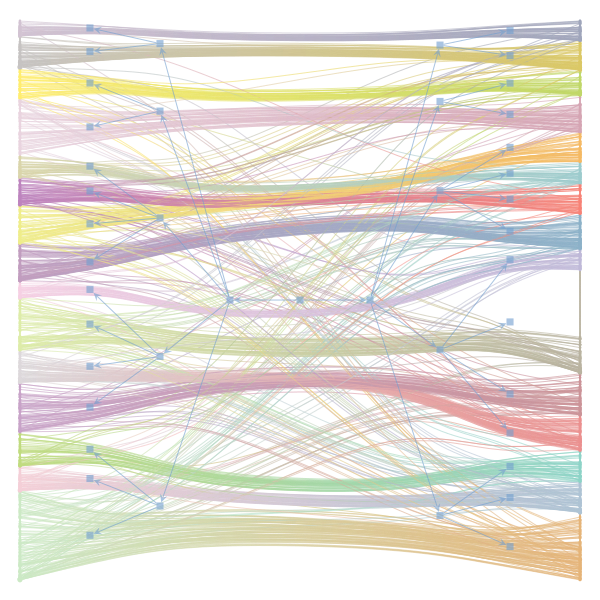

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa4498c5198, at 0x7fa43c7e1eb8>,
 <Graph object, directed, with 3812 vertices and 3811 edges at 0x7fa43c85c668>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa43c85c668, at 0x7fa43c73f550>)

In [22]:
gt.draw_hierarchy(state,layout='bipartite',\
              output=None,\
              subsample_edges=1000,\
              hshortcuts=1, hide=0,\
              beta=0.5
              )

In [23]:
blocks = state.get_bs()[0]


# Genres - Community relations

## Raw frequency of genres in communities

In [24]:
genre_dict = list(movie_producer_df[['genres']].to_dict().values())[0]

### Movies with multiple genres

In [25]:
blocks = state.get_levels()[0]
blocks

<BlockState object with 30 blocks (30 nonempty), degree-corrected, for graph <Graph object, undirected, with 3769 vertices and 6751 edges at 0x7fa4498c5198>, at 0x7fa43c80ca20>

In [26]:
block_genre_dictionary = {}
all_genres = []
for v in G.vertices():
    if G.vp.kind[v] == 0: #if the vertex is movie:
        title = G.vp.name[v]
        genres = movie_producer_df[movie_producer_df.index == title].genres.tolist()
        genres = [g for sub_genre in genres for g in sub_genre]
        block = blocks.get_blocks()[v]
        #if block does not exist in key, add block
        if block not in block_genre_dictionary:
            block_genre_dictionary[block] = genres
        else:
            block_genre_dictionary[block].extend(genres)
        all_genres.extend(genres)

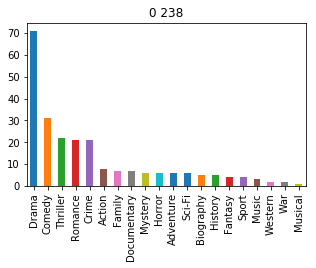

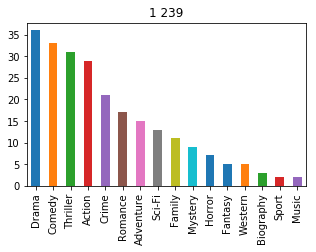

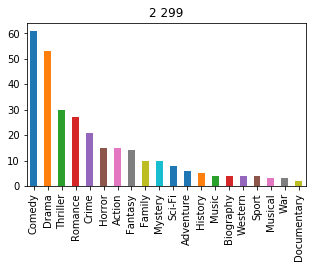

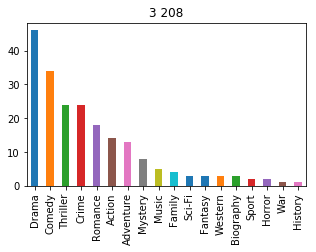

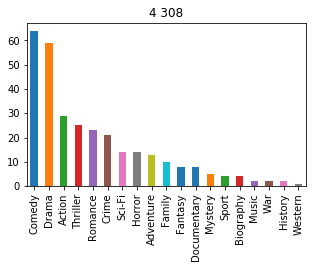

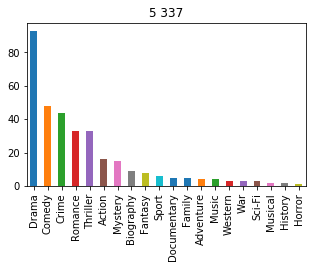

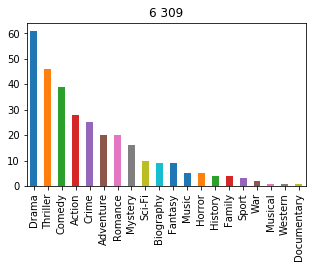

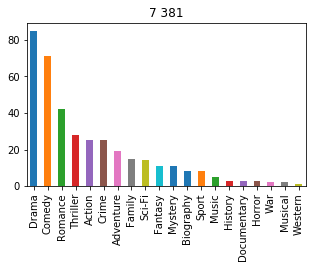

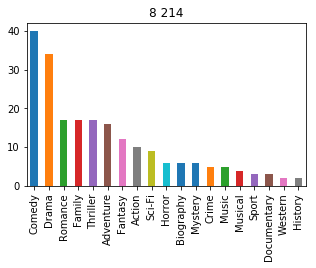

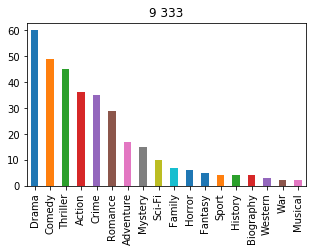

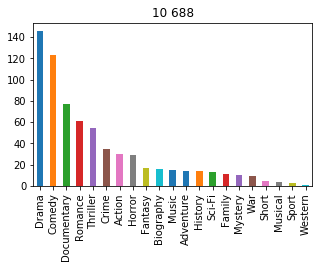

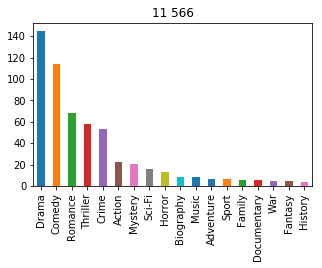

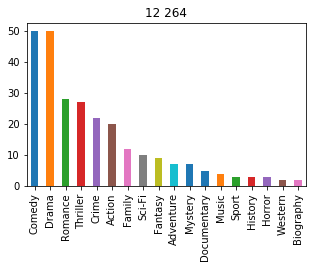

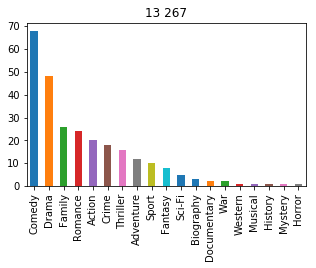

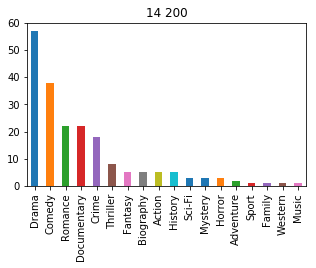

In [27]:
genre_list = list(set(all_genres))

for i, v in block_genre_dictionary.items():
    freq_series = pd.Series(v, name=i)
    fig, ax = plt.subplots(figsize=(5,3))
    freq_series.value_counts().plot(kind='bar', ax=ax)
    ax.set_title('{} {}'.format(i, len(freq_series)))

In [28]:
genre_block_df = pd.DataFrame(0, columns=genre_list, index=block_genre_dictionary.keys())
for i, v in block_genre_dictionary.items():
    freq_dict = Counter(v)
    genre_block_df.loc[i] = pd.DataFrame(freq_dict, index=[i]).loc[i]
genre_block_df=genre_block_df.fillna(0)
genre_block_df

,History,Documentary,Romance,Mystery,Sci-Fi,Fantasy,Action,Adventure,Thriller,Biography,...,War,Western,Short,Musical,Horror,Drama,Crime,Comedy,Family,Sport
0,5.0,7.0,21.0,6.0,6.0,4.0,8.0,6.0,22.0,5.0,...,2.0,2.0,0.0,1.0,6.0,71.0,21.0,31.0,7.0,4.0
1,0.0,0.0,17.0,9.0,13.0,5.0,29.0,15.0,31.0,3.0,...,0.0,5.0,0.0,0.0,7.0,36.0,21.0,33.0,11.0,2.0
2,5.0,2.0,27.0,10.0,8.0,14.0,15.0,6.0,30.0,4.0,...,3.0,4.0,0.0,3.0,15.0,53.0,21.0,61.0,10.0,4.0
3,1.0,0.0,18.0,8.0,3.0,3.0,14.0,13.0,24.0,3.0,...,1.0,3.0,0.0,0.0,2.0,46.0,24.0,34.0,4.0,2.0
4,2.0,8.0,23.0,5.0,14.0,8.0,29.0,13.0,25.0,4.0,...,2.0,1.0,0.0,0.0,14.0,59.0,21.0,64.0,10.0,4.0
5,2.0,5.0,33.0,15.0,3.0,8.0,16.0,4.0,33.0,9.0,...,3.0,3.0,0.0,2.0,1.0,93.0,44.0,48.0,5.0,6.0
6,4.0,1.0,20.0,16.0,10.0,9.0,28.0,20.0,46.0,9.0,...,2.0,1.0,0.0,1.0,5.0,61.0,25.0,39.0,4.0,3.0
7,3.0,3.0,42.0,11.0,14.0,11.0,25.0,19.0,28.0,8.0,...,2.0,1.0,0.0,2.0,3.0,85.0,25.0,71.0,15.0,8.0
8,2.0,3.0,17.0,6.0,9.0,12.0,10.0,16.0,17.0,6.0,...,0.0,2.0,0.0,4.0,6.0,34.0,5.0,40.0,17.0,3.0
9,4.0,0.0,29.0,15.0,10.0,5.0,36.0,17.0,45.0,4.0,...,2.0,3.0,0.0,2.0,6.0,60.0,35.0,49.0,7.0,4.0


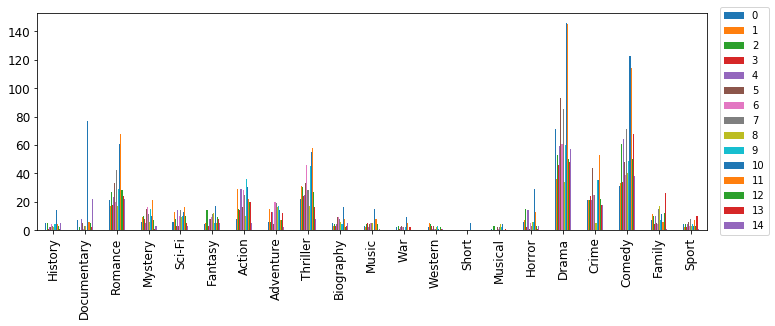

In [29]:
fontsize=12
fig, ax = plt.subplots(figsize=(12,4))
genre_block_df.T.plot(kind='bar', ax=ax, fontsize=fontsize)
ax.legend(bbox_to_anchor=(1.1, 1.05))

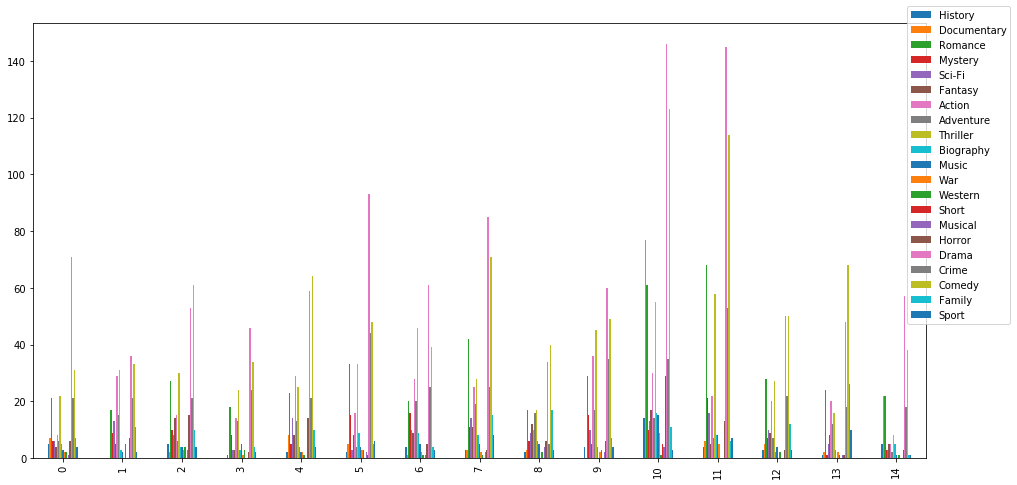

In [30]:
fig, ax = plt.subplots(figsize=(16,8))
genre_block_df.plot(kind='bar', ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05))

### Which genres appear together?

In [32]:
genre_order_df = pd.DataFrame(0, columns=range(len(genre_list)), index=block_genre_dictionary.keys())
for block, row in genre_block_df.iterrows():
    genre_order_df.loc[block] = row.sort_values(ascending=False).index

In [33]:
genre_order_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Drama,Comedy,Thriller,Crime,Romance,Action,Documentary,Family,Horror,Mystery,...,Adventure,History,Biography,Fantasy,Sport,Music,War,Western,Musical,Short
1,Drama,Comedy,Thriller,Action,Crime,Romance,Adventure,Sci-Fi,Family,Mystery,...,Fantasy,Western,Biography,Sport,Music,War,Short,Musical,Documentary,History
2,Comedy,Drama,Thriller,Romance,Crime,Horror,Action,Fantasy,Mystery,Family,...,Adventure,History,Sport,Biography,Western,Music,War,Musical,Documentary,Short
3,Drama,Comedy,Crime,Thriller,Romance,Action,Adventure,Mystery,Music,Family,...,Western,Fantasy,Biography,Sport,Horror,War,History,Short,Musical,Documentary
4,Comedy,Drama,Action,Thriller,Romance,Crime,Horror,Sci-Fi,Adventure,Family,...,Documentary,Mystery,Sport,Biography,Music,War,History,Western,Short,Musical
5,Drama,Comedy,Crime,Romance,Thriller,Action,Mystery,Biography,Fantasy,Sport,...,Family,Adventure,Music,War,Western,Sci-Fi,Musical,History,Horror,Short
6,Drama,Thriller,Comedy,Action,Crime,Adventure,Romance,Mystery,Sci-Fi,Fantasy,...,Music,Horror,History,Family,Sport,War,Western,Musical,Documentary,Short
7,Drama,Comedy,Romance,Thriller,Crime,Action,Adventure,Family,Sci-Fi,Mystery,...,Sport,Biography,Music,Horror,Documentary,History,War,Musical,Western,Short
8,Comedy,Drama,Romance,Family,Thriller,Adventure,Fantasy,Action,Sci-Fi,Horror,...,Biography,Music,Crime,Musical,Documentary,Sport,Western,History,War,Short
9,Drama,Comedy,Thriller,Action,Crime,Romance,Adventure,Mystery,Sci-Fi,Family,...,Fantasy,Sport,History,Biography,Western,War,Musical,Short,Documentary,Music


In [34]:
drama_comedy_counter = 0
num_genres = []
no_genre_counter = 0
spec_genre = ['Drama', 'Comedy']
for i, row in movie_producer_df.iterrows():
    genres = row.genres
    if spec_genre < genres:
        drama_comedy_counter += 1
    num_genres.append(len(genres))
    if len(genres) == 0:
        print(row)
        no_genre_counter += 1

producers                      [[nm0134067, co-producer], [nm2401342, associa...
producing_gender_percentage                                                    0
title                                                                      Drive
year                                                                        1991
genres                                                                        []
Name: tt0101773, dtype: object
producers                      [[nm0742761, producer]]
producing_gender_percentage                          0
title                             The Bed You Sleep In
year                                              1993
genres                                              []
Name: tt0106372, dtype: object
producers                      [[nm0424898, executive producer], [nm0518910, ...
producing_gender_percentage                                                    0
title                                                                Golden Gate
year           

In [35]:
drama_comedy_counter, no_genre_counter, len(movie_producer_df)

(340, 17, 2009)

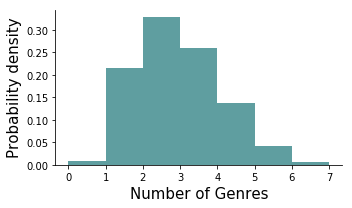

In [36]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(num_genres, bins=np.arange(0, max(num_genres)+1, 1), color='cadetblue',density=True)
fontsize=10
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Number of Genres', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
# plt.savefig('/home/projects/movie-network/result/basic_properties/90s_num_genres_per_movie.pdf', dpi=300, transparent=True)

##  Normalized frequencey relationship between g (genres) and c (community)

$$P(g|c) = \frac{P(g,c)}{P(c)}$$

$$R = \frac{P(g|c)}{P(c)} = \frac{P(g,c)}{P(c)*P(g)}$$

$$=\frac{\frac{n(g,c)}{N}}{\frac{n(c)}{N} \times \frac{n(g)}{N}}$$

$$=\frac{n(g,c) \times N} {n(c) \times n(g)}$$

In [42]:
block_list = list(block_genre_dictionary.keys())
df_R = pd.DataFrame(index=sorted(block_list), columns=sorted(genre_list))

In [45]:
N = genre_block_df.sum().sum()
for c in block_list:
    for g in genre_list:
        df_R.at[c,g] = genre_block_df[g][c]*N/(genre_block_df.loc[c].sum()*genre_block_df[g].sum())

In [46]:
df_R

,Action,Adventure,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,0.531136,0.71517,1.14508,0.732159,1.10317,1.01189,1.38616,0.977236,0.662841,1.85294,...,0.970588,1.01912,0.855204,0.951176,0.892658,0,1.2739,0.964326,1.23529,1.35882
1,1.91731,1.78044,0.684171,0.776134,1.09855,0,0.699899,1.52923,0.825084,0,...,0.644351,0,1.27744,0.766778,1.926,0,0.634283,1.35314,0,3.38285
2,0.792708,0.569266,0.729172,1.14678,0.878107,0.230129,0.823636,1.11124,1.84664,1.47492,...,1.0301,2.43361,1.13455,0.973445,0.947392,0,1.01401,1.04671,1.47492,2.16321
3,1.06355,1.77303,0.786139,0.918832,1.44261,0,1.0276,0.638962,0.568832,0.424038,...,1.85096,0,1.30473,0.932885,0.510703,0,0.728816,1.20372,0.706731,2.33221
4,1.48779,1.19737,0.707865,1.16802,0.852448,0.893617,0.890086,1.07877,1.02439,0.572727,...,0.5,0,0.550699,0.805,1.60949,0,0.984375,0.846774,0.954545,0.525
5,0.75021,0.336717,1.45564,0.80063,1.63238,0.510449,1.28228,0.492968,0.936238,0.523442,...,0.913947,1.43947,1.50993,1.05561,0.315212,0,1.3495,1.02156,1.30861,1.43947
6,1.43183,1.83614,1.58754,0.709458,1.01154,0.111341,0.91728,0.43011,1.14871,1.14175,...,1.24595,0.784951,1.75653,0.697735,1.14591,0,0.735892,1.55302,0.951456,0.523301
7,1.03683,1.4147,1.14447,1.0475,0.820379,0.2709,1.03663,1.30811,1.13866,0.694488,...,1.0105,1.27323,0.979406,1.18835,1.30111,0,1.59154,0.766675,0.771654,0.424409
8,0.738379,2.121,1.52819,1.05067,0.292116,0.482303,0.738237,2.63945,2.21153,0.824299,...,1.79907,4.53364,0.951114,0.856355,1.48915,0,1.06257,0.828731,0,1.51121
9,1.70825,1.44824,0.654722,0.827127,1.31408,0,0.837217,0.698445,0.592178,1.05946,...,0,1.45676,1.52807,0.938799,1.06333,0,0.910473,1.40976,0.882883,1.45676


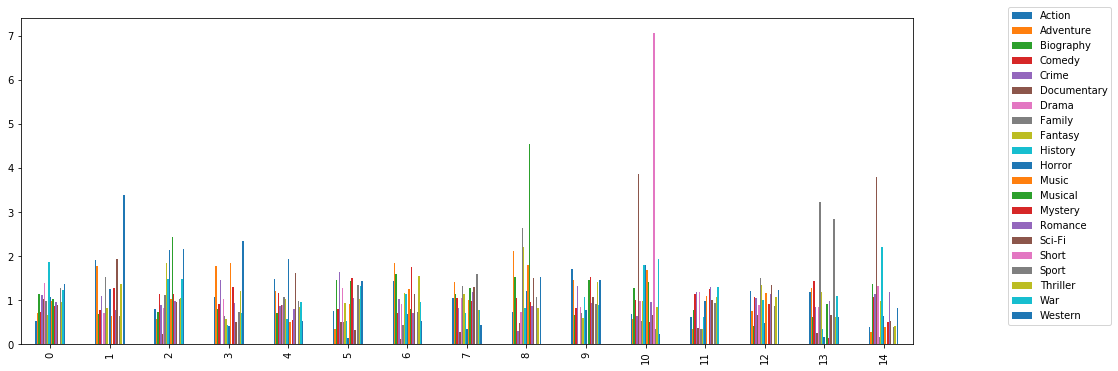

In [48]:
fig, ax = plt.subplots(figsize=(16,6))
df_R.plot(kind='bar', ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [51]:
df_R_log = df_R.applymap(np.log).replace([np.inf, -np.inf], np.nan)

/home/staff/junelee/miniconda3/envs/movie_network/lib/python3.6/site-packages/pandas/core/frame.py:6070: RuntimeWarning: divide by zero encountered in log
  return lib.map_infer(x.astype(object).values, func)


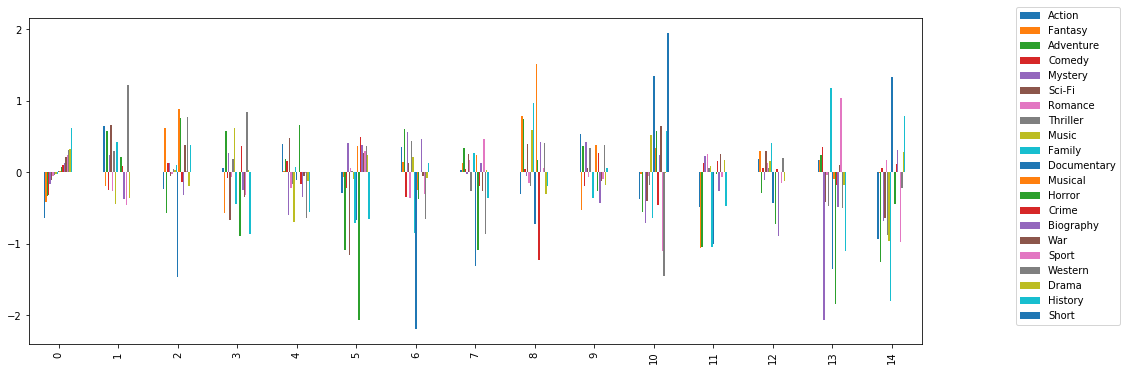

In [62]:
fig, ax = plt.subplots(figsize=(16,6))
sorted_df_R_log = df_R_log.sort_values(by=0,axis=1)
sorted_df_R_log.plot(kind='bar', ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05))

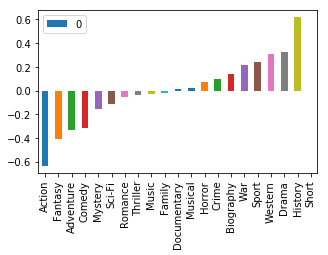

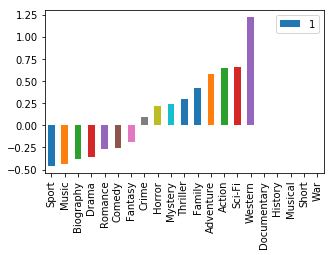

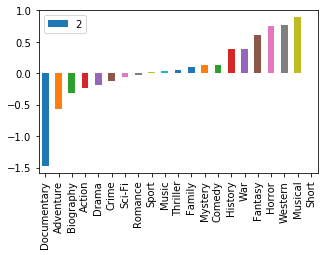

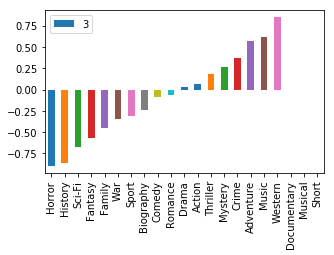

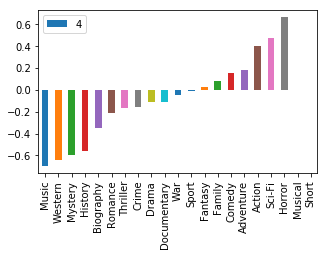

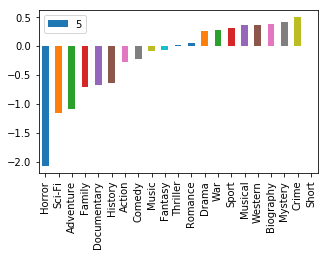

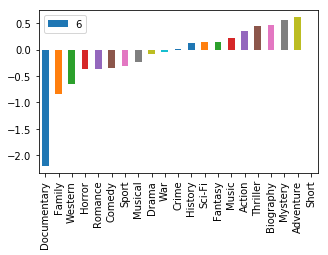

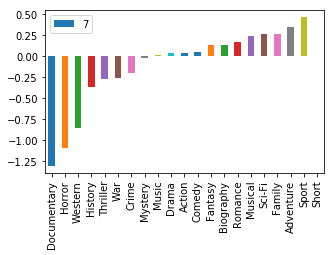

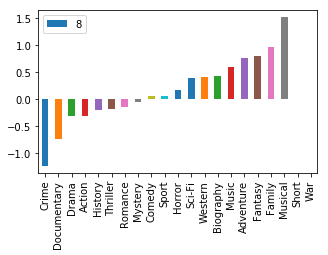

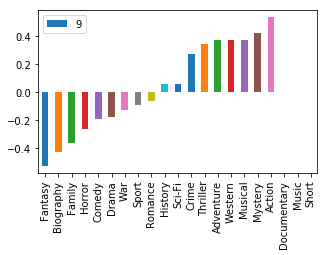

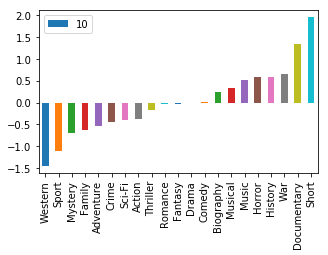

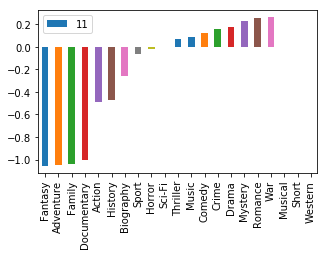

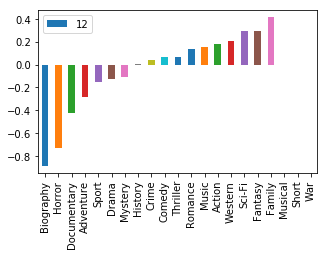

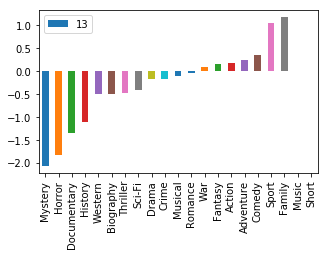

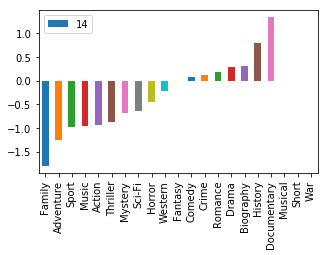

In [55]:
for i, row in df_R_log.iterrows():
    fig, ax = plt.subplots(figsize=(5,3))
    sorted_vals = row.sort_values()
    sorted_vals.plot(kind='bar', ax=ax)
    ax.legend()